Here we will create a simple model for predicting the values of a linear regression 

In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import random
#from ipynb.fs.full.Graphic_2_Linear_regression import Synthetic_data # Own package, this one will provide a synthetic dataset
from synthetic_data import Synthetic_data

In [2]:
class littleTrainModel:
    """
    This is a class created to train a simple model and predicting the values w, and b of a linear regresion given in
    way of data set, each row is a line and the features are the independant variables, and the label is the 
    dependant variable.
    
    Attributes:
    
            dataset_train(tuple)     = Dataset which will be our dataset of training, must be made up of two tensors, 
                                        the first one contain the features, and the second one the labels or can be
                                        created with Graphic_2_Linear_regression module.
            lr(float)                = learning rate
            epochs(int)              = number of epoch
            bacthSize(int)           = length of minibatches which will be used for training the model
            dataSetValidation(tuple) = If isn't entered will be assigned equal to dataset_train
            netFunc(function)        = if isn't assigned will be equal to a linear regresion
            lossFunc(function)       = if isn't assigned will be equal to a squared error 
                                  
    
    Example::
          
        >> dataset_train  = Synthetic_data([2, -3.4],4,2, 1000).yield_data() -> dataset with parameters w[2, 3.4] and b = 4.2
                            and 1000 examples.
        
        >> model = littleTrainModel(dataset_train, 0.03, 4, 10) 
        >> model.makePrediction()
            epoch 1, loss 0.039874
            epoch 2, loss 0.000104
            epoch 3, loss 0.000000
            epoch 4, loss 0.000000   
            
        The parameters predicted w and b are stored as attributes and can be accessed if you wish
        
        >> model.w 
           tensor([[ 2.0000],[-3.4000]], requires_grad=True),
 
        >>model.b  
           tensor([4.2000], requires_grad=True))
           
         Notes: 
                -In this case by the simplicity of the model and that the train and validation model are de same
                 we have a error of zero.
               - Because the assuption this module is obiously overfit, somethig that in the real world is for nothing 
                 desired 
    """
    
    
    def __init__(self, dataSetTrain, lr, epochs, batchSize, dataSetValidation=None, netFunc='linreg', lossFunc='squared_loss'):
        self.w = torch.normal(0, 0.1, size=(2,1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        self.dataSetTrain = dataSetTrain
        self.lr = lr
        self.epochs = epochs        
        self.batchSize = batchSize
        self.netFunc = netFunc
        self.lossFunc = lossFunc
        self.errors = []
        
        if dataSetValidation != None:         # If you wish put other dataset as a trining data
            self.dataSetValidation = dataSetValidation
        else:
            self.dataSetValidation = dataSetTrain
        
    def net(self, X, w, b):                   # lineal regresion in a matriz fashion
        if self.netFunc == 'linreg':
            return torch.matmul(X,w) + b
        else:
            return self.netFunc(X,w,b)
    
    def loss(self,y_hat, y):                  # squared loss function
        if self.lossFunc == 'squared_loss':
            return ((y_hat- y.reshape(y_hat.shape))**2)/2 
        else:
            return self.loss(y_hat, y)
    
    def sgd(self, params, lr, batch_size):    # Stochastic gradient descend function
        with torch.no_grad():             # torch.no_grad because this ones will be calculated in the training
            for param in params:
                param -= lr*param.grad / batch_size  
                param.grad.zero_() 
    
    def dataIter(self, batchSize):       #  suffle the data for more randomness 
        minibatch_features, minibatch_labels = self.dataSetValidation
        num_examples = len(minibatch_features)   
        indices = list(range(num_examples))  
        random.shuffle(indices) 
        for i in range(0, num_examples, batchSize):  
            batch_indices = indices[i: min(i + batchSize, num_examples)]  
            yield self.dataSetValidation[0][batch_indices], self.dataSetValidation[1][batch_indices] 
       
    def makePrediction(self):      
        error = []
        for epoch in range(self.epochs):   
            for X,y in self.dataIter(self.batchSize):    # catch one minibatch and start to operate over it
                l = self.loss(self.net(X, self.w,self.b),y) # make the loss between predicted and labels
                # backward pass
                l.sum().backward()   # doing the sum because backward must be perfomed over a scalar
                # forward pass
                self.sgd([self.w,self.b], self.lr, self.batchSize) # apply the update of  w and b  
            with torch.no_grad(): # for each opoch calculate the loss
                train_l = self.loss(self.net(self.dataSetValidation[0],self.w,self.b),self.dataSetValidation[1])
                self.errors.append(float(train_l.mean()))
                print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}') # uncomment to see the each loss

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
dataset_train = Synthetic_data(true_w, true_b, 1000).yield_data()
model = littleTrainModel(dataset_train, 0.03, 4, 10)
print(model.w, model.b)

tensor([[0.2094],
        [0.0478]], requires_grad=True) tensor([0.], requires_grad=True)


In [4]:
model.makePrediction()

epoch 1, loss 0.035206
epoch 2, loss 0.000077
epoch 3, loss 0.000000
epoch 4, loss 0.000000


# Excercises

**1.** What would happen if we were to initialize the weights to zero. Would the algorithm still
work?

As the funtion has the way $ Y = X*w + b$ and the backwards is calculated as the derivate of a sum, we have then that the gradient is $ \sum_{i=0}^{n} =  \begin{bmatrix} \frac{\partial Y}{\partial w} \\ \frac{\partial Y}{\partial w} \end{bmatrix} = \sum_{i=0}^{n} \begin{bmatrix} X \\ 1 \end{bmatrix} $ then the gradiend doesn't depend on the initials values w and b.

And as the funtion that we are using to measure the error is a squared error and this one has a unique minima,( is practically a parabola), there is no problem with initializing in zero, because wouldn't be problem of achieve a local minimum.


In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
dataset_train = Synthetic_data(true_w, true_b, 1000).yield_data()
model = littleTrainModel(dataset_train, 0.03, 4, 10)
print(model.w, model.b)

tensor([[-0.0229],
        [ 0.0869]], requires_grad=True) tensor([0.], requires_grad=True)


In [6]:
model.makePrediction()

epoch 1, loss 0.047506
epoch 2, loss 0.000144
epoch 3, loss 0.000000
epoch 4, loss 0.000000


**2.** why does the following torch.matmul operation raise the **RuntimeError: expected scalar type Long but found Float** error? 

<code>true_w = torch.tensor([2, -3.])
true_b = 4
features = torch.tensor([[5,4],[3,2]])
labels = torch.matmul(features,true_w) + true_b
</code>

The answer is because Pytorch can't perfom broadcasting operations over a different Data types for example in the above snippet the value true_w has assigned a torch.float32 while the features has torch.int64

<code>\>> print(true_w.dtype)
\>> torch.float32

\>> print(features.dtype)
\>> torch.int64</code>

If in the previous code the -3.0 is change by a -3, then the equation can be performed.

__3__ Why is the reshape function needed in the squared_loss function?

### Loss function
<code>
 def loss(self,y_hat, y):            
        if self.lossFunc == 'squared_loss':
            return ((y_hat- y.reshape(y_hat.shape))**2)/2 
        else:
            return self.loss(y_hat, y)</code>
            
### Loss function in the epochs
<code>
for epoch in range(self.epochs):       
    for X,y in self.dataIter(self.batchSize): 
        l = self.loss(self.net(X, self.w,self.b),y) 
</code>

### net function that is the first input of the Loss function

<code>def net(self, X, w, b):     
        if self.netFunc == 'linreg':
          return torch.matmul(X,w) + b
</code>

The caller of the loss function requiere two inputs, the first one the net that perform the prediction, and the second one the labels (true values), as the net return the result of a multiplication this one has one shape of \[num_examples\] and the __y__ (labels) has one shape of [numexample, 1], the followin example, show the shapes of the y_hat and y

In [7]:
w = torch.tensor([2, -3.])
b = 4
data =  Synthetic_data(w,b, 10).yield_data()
X = data[0]
y_hat = data[1]
y_hat.shape

torch.Size([10, 1])

In [8]:
def net(X, w, b):
        return torch.matmul(X,w) + b
y = net(X,w,b)

In [9]:
y.shape

torch.Size([10])

Therefore if we perform y_hat - y we get a broadcasting of every y_hat's row with every column, and then finally we would get a tensor that is not the desired 

__3.__ Experiment using different learning rates to find out how fast the loss function value drops.

In [10]:
lrs = [0.1, 0.08, 0.06, 0.04, 0.02, 0.001,0.0001]
w = torch.tensor([2, -3.4])
b = 4.2
num_examples = 1000
epochs = 3

class ErrorDependOnLr:
    
    def __init__(self, lrs, w, b, num_examples, epochs):
          
        self.lrs = lrs
        self.w = w
        self.b = b
        self.num_examples = num_examples
        self.epochs = epochs
        self.errors = []
        
    def EpochError(self):
        errors = []
        dataset_train = Synthetic_data(self.w , self.b, self.num_examples).yield_data()

        for lr in self.lrs: 
            model = littleTrainModel(dataset_train, lr, self.epochs, 10)
            model.makePrediction()
            self.errors.append(model.errors[self.epochs-1])
        
    def graph(self):
        self.EpochError()
        ax = plt.axes()
        plt.title('Errors depend on Learning rate')
        plt.grid(True)
        ax.set_xlabel('x')
        ax.set_ylabel('Error')
        ax.axis([0.8, 6.2, -0.5, 10])
        labels = self.lrs
        
        for point in enumerate(self.errors, start=1):
            ax.scatter(point[0],point[1])
            ax.legend(labels)

In [11]:
errors = ErrorDependOnLr(lrs, w, b, num_examples, epochs)

epoch 1, loss 0.000000
epoch 2, loss 0.000000
epoch 3, loss 0.000000
epoch 1, loss 0.000001
epoch 2, loss 0.000000
epoch 3, loss 0.000000
epoch 1, loss 0.000088
epoch 2, loss 0.000000
epoch 3, loss 0.000000
epoch 1, loss 0.005282
epoch 2, loss 0.000002
epoch 3, loss 0.000000
epoch 1, loss 0.297496
epoch 2, loss 0.005735
epoch 3, loss 0.000113
epoch 1, loss 13.687961
epoch 2, loss 11.252166
epoch 3, loss 9.250182
epoch 1, loss 16.321453
epoch 2, loss 16.004808
epoch 3, loss 15.694309


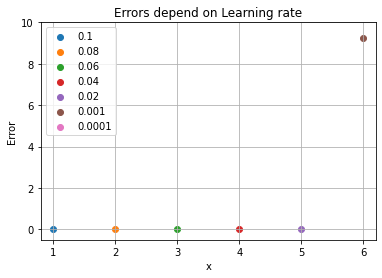

In [12]:
errors.graph()

In [13]:
errors.errors

[4.692992413950214e-13,
 5.142055401266554e-13,
 1.9405490669227587e-12,
 7.494685982933902e-10,
 0.00011285708023933694,
 9.250182151794434,
 15.69430923461914]